In [1]:
import cvxpy as cp
import numpy as np
import itertools
import pickle


class OptimizationProblem:
    def __init__(self, K, R, L, lmbda=None, b=None, verbose=1, tolerance=1e-8):
        self.K = K
        self.R = R
        self.L = L
        self.verbose = verbose
        self.tolerance = tolerance

        # If b is not provided, generate a random one
        self.b = b if b is not None else np.random.rand(K) / (1000)

        # If lmbda is not provided, generate a random one and set the first element to 1
        self.lmbda = lmbda if lmbda is not None else np.random.rand(K + 1)
        self.lmbda[0] = 1

        self.a = np.zeros(K + 1)
        self.a[0] = 1
        self.A = np.zeros(K + 1)
        self.A[0] = 1
        self.theta = np.zeros((K, K))

        self._calculate_sequences()
        self._define_matrices()

        # To store the solution
        self.status = None
        self.v_i_value = None
        self.v_si_value = None
        self.E_value = None
        self.u_value = None

    def _calculate_sequences(self):
        for i in range(self.K):
            self.a[i + 1] = (
                self.lmbda[i + 1]
                + np.sqrt(4 * self.lmbda[i + 1] * self.A[i] + self.lmbda[i + 1] ** 2)
            ) / 2
            self.A[i + 1] = self.A[i] + self.a[i + 1]

        for k in range(self.K):
            for i in range(self.K):
                if i == k:
                    self.theta[k, i] = (
                        1 + (2 * self.a[k] - 1) * self.a[k + 1] / self.A[k + 1]
                    )
                else:
                    if i > k:
                        break
                    self.theta[k, i] = (self.a[k + 1] / self.A[k + 1]) * (
                        2 * self.a[i] - self.theta[k - 1, i]
                    ) + self.theta[k - 1, i]

    def _define_matrices(self):
        K = self.K
        L = self.L

        self.dimG = 2 * K + 2
        self.dimF = K + 1

        self.f = np.matrix(np.eye(K + 1))
        self.fs = np.zeros((K + 1, 1))

        self.xs = np.zeros((2 * K + 2, 1))

        self.e = np.matrix(np.zeros((2 * K + 2, K)))
        self.e[1 : K + 1, :] = np.eye(K)
        self.g = np.matrix(np.zeros((2 * K + 2, K + 1)))
        self.g[K + 1 :, :] = np.eye(K + 1)
        self.gs = np.zeros((2 * K + 2, 1))

        self.xi = np.matrix(np.zeros((2 * K + 2, K + 1)))
        self.xi[0] = 1

        for k in range(K):
            temp = self.xi[:, 0]
            for i in range(k + 1):
                temp = temp - 1 / L * self.theta[k, i] * (self.e[:, i] + self.g[:, i])
            self.xi[:, k + 1] = temp

    def solve(self):
        K = self.K
        L = self.L
        R = self.R
        tolerance = self.tolerance

        v_i = cp.Variable((K), nonneg=True)
        v_si = cp.Variable(K + 1, nonneg=True)
        tau = cp.Variable(1, nonneg=True)
        u = cp.Variable(K, nonneg=True)
        E = cp.Variable(1, nonneg=True)

        constraints = [v_i >= 0, v_si >= 0, tau == L / (4 * self.A[K]), u >= 0]

        func_linear = self.f[:, -1] + v_si[K] * (self.fs - self.f[:, K])
        for i in range(K):
            func_linear = (
                func_linear
                + v_i[i] * (self.f[:, i] - self.f[:, i + 1])
                + v_si[i] * (self.fs - self.f[:, i])
            )

        func_PSD = (
            (tau) * self.xi[:, 0] @ self.xi[:, 0].T
            + 1 / (2 * L) * self.g[:, K] @ self.g[:, K].T
        )

        for i in range(K):
            Aij = (
                1
                / 2
                * (
                    (self.xi[:, i] - self.xi[:, i + 1]) @ self.g[:, i + 1].T
                    + self.g[:, i + 1] @ (self.xi[:, i] - self.xi[:, i + 1]).T
                )
                + 1
                / (2 * L)
                * (self.g[:, i] - self.g[:, i + 1])
                @ (self.g[:, i] - self.g[:, i + 1]).T
            )
            Asi = (
                1
                / 2
                * (
                    (self.xs - self.xi[:, i]) @ self.g[:, i].T
                    + self.g[:, i] @ (self.xs - self.xi[:, i]).T
                )
                + 1 / (2 * L) * (self.gs - self.g[:, i]) @ (self.gs - self.g[:, i]).T
            )
            func_PSD = (
                func_PSD
                + v_i[i] * Aij
                + v_si[i] * Asi
                + u[i] * self.e[:, i] @ self.e[:, i].T
            )

        i = K
        Asi = (
            1
            / 2
            * (
                (self.xs - self.xi[:, i]) @ self.g[:, i].T
                + self.g[:, i] @ (self.xs - self.xi[:, i]).T
            )
            + 1 / (2 * L) * (self.gs - self.g[:, i]) @ (self.gs - self.g[:, i]).T
        )
        func_PSD = func_PSD + v_si[i] * Asi

        constraints += [func_linear == 0]
        constraints += [func_PSD >> 0]
        obj = cp.Minimize((tau) * R**2 + self.b @ u)

        solver_opt = {
            "solver": "MOSEK",
            "verbose": self.verbose,
            "mosek_params": {"MSK_DPAR_INTPNT_CO_TOL_PFEAS": tolerance},
        }
        prob = cp.Problem(obj, constraints)
        prob.solve(**solver_opt)

        # Store the solution in the class attributes
        self.status = prob.status
        self.v_i_value = v_i.value
        self.v_si_value = v_si.value
        self.E_value = E.value
        self.u_value = u.value

        # # Print status
        # print("status:", self.status)
        # print("max absolute difference in v_i:", max(abs(self.v_i_value - self.A[0:self.K] / self.A[self.K])))
        # print("absolute value of E:", abs(self.E_value))

        # return self.status, self.v_i_value, self.E_value


# # Example usage with custom lmbda and b
# K = 100
# lmbda = np.array([1] + list(np.random.rand(K)))
# # lmbda = np.random.rand(K+1)
# b = np.random.rand(K) * 1

# opt_problem = OptimizationProblem(K=K, R=10, L=5, lmbda=lmbda, b=b, verbose=1)
# status, v_i, E = opt_problem.solve()

In [2]:
# Define the ranges of K, R, and L values
K_values = np.linspace(10, 90, 9, dtype=int)
R_values = [1, 10, 1000]
L_values = [1, 10, 1000]

# Generate all combinations of K, R, and L values
combinations = itertools.product(K_values, R_values, L_values)

# Number of random lambda and b values to generate for each combination
N = 10

# To store the class instances for each combination and each random setting
opt_problems = {}

# Set a random seed for reproducibility
np.random.seed(8)

# Repeat the experiment for different values of K, R, L and save the class instance
for i, (K, R, L) in enumerate(combinations):
    for j in range(N):
        # Generate random lambda and b values
        lmbda = np.random.rand(K + 1)
        lmbda[0] = 1
        b = np.random.rand(K) / (5000)

        # Create a new OptimizationProblem instance with the generated parameters
        opt_problem_key = (i, j)
        opt_problems[opt_problem_key] = OptimizationProblem(
            K=K, R=R, L=L, lmbda=lmbda, b=b, verbose=0
        )

        # Solve the optimization problem
        opt_problems[opt_problem_key].solve()

        # Print the results for this setting
        print(f"Setting {opt_problem_key}: K={K}, R={R}, L={L}")
        print("Status:", opt_problems[opt_problem_key].status)
        print(
            "Max error of v_i:",
            max(
                abs(
                    opt_problems[opt_problem_key].v_i_value
                    - opt_problems[opt_problem_key].A[
                        0 : opt_problems[opt_problem_key].K
                    ]
                    / opt_problems[opt_problem_key].A[opt_problems[opt_problem_key].K]
                )
            ),
        )
        print("Stored E:", opt_problems[opt_problem_key].E_value)
        print("\n")

# Save the results with pickle
# with open("opt_problems_K90.pickle", "wb") as handle:
#     pickle.dump(opt_problems, handle, protocol=pickle.HIGHEST_PROTOCOL)

Setting (0, 0): K=10, R=1, L=1
Status: optimal
Max error of v_i: 0.02692595594751479
Stored E: None


Setting (0, 1): K=10, R=1, L=1
Status: optimal
Max error of v_i: 0.05975744037868991
Stored E: None


Setting (0, 2): K=10, R=1, L=1
Status: optimal
Max error of v_i: 0.025939755522663144
Stored E: None


Setting (0, 3): K=10, R=1, L=1
Status: optimal
Max error of v_i: 0.027456515482930488
Stored E: None


Setting (0, 4): K=10, R=1, L=1
Status: optimal
Max error of v_i: 0.025122722212156834
Stored E: None


Setting (0, 5): K=10, R=1, L=1
Status: optimal
Max error of v_i: 0.0652723492035231
Stored E: None


Setting (0, 6): K=10, R=1, L=1
Status: optimal
Max error of v_i: 0.04548685315795631
Stored E: None


Setting (0, 7): K=10, R=1, L=1
Status: optimal
Max error of v_i: 0.06228457278235677
Stored E: None


Setting (0, 8): K=10, R=1, L=1
Status: optimal
Max error of v_i: 0.0317400656850203
Stored E: None


Setting (0, 9): K=10, R=1, L=1
Status: optimal
Max error of v_i: 0.04664828422630

KeyboardInterrupt: 

In [ ]:
# Define the ranges of K, R, and L values
K_values = [100]
R_values = [1, 10, 1000]
L_values = [1, 10, 1000]

# Generate all combinations of K, R, and L values
combinations = itertools.product(K_values, R_values, L_values)

# Number of random lambda and b values to generate for each combination
N = 10

# To store the class instances for each combination and each random setting
opt_problems = {}

# Set a random seed for reproducibility
np.random.seed(6)

# Repeat the experiment for different values of K, R, L and save the class instance
for i, (K, R, L) in enumerate(combinations):
    for j in range(N):
        # Generate random lambda and b values
        lmbda = np.random.rand(K + 1)
        lmbda[0] = 1
        b = np.random.rand(K) / (5000)

        # Create a new OptimizationProblem instance with the generated parameters
        opt_problem_key = (i+81, j)
        opt_problems[opt_problem_key] = OptimizationProblem(
            K=K, R=R, L=L, lmbda=lmbda, b=b, verbose=0
        )

        # Solve the optimization problem
        opt_problems[opt_problem_key].solve()

        # Print the results for this setting
        print(f"Setting {opt_problem_key}: K={K}, R={R}, L={L}")
        print("Status:", opt_problems[opt_problem_key].status)
        print(
            "Max error of v_i:",
            max(
                abs(
                    opt_problems[opt_problem_key].v_i_value
                    - opt_problems[opt_problem_key].A[
                        0 : opt_problems[opt_problem_key].K
                    ]
                    / opt_problems[opt_problem_key].A[opt_problems[opt_problem_key].K]
                )
            ),
        )
        print("Stored E:", opt_problems[opt_problem_key].E_value)
        print("\n")

# Save the results with pickle
with open("opt_problems_K100.pickle", "wb") as handle:
    pickle.dump(opt_problems, handle, protocol=pickle.HIGHEST_PROTOCOL)

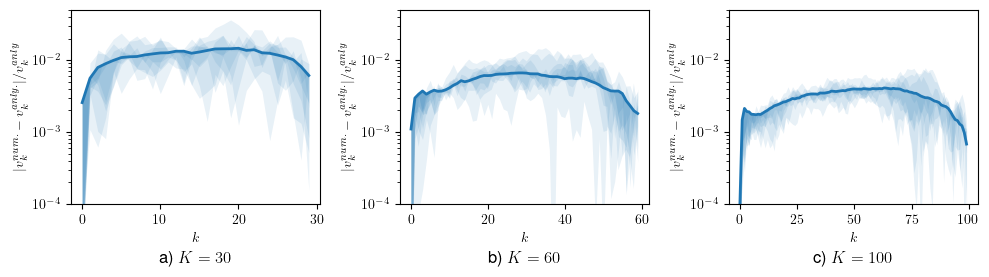

In [59]:
import matplotlib.pyplot as plt

plt.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "sans-serif",
        "font.sans-serif": ["Helvetica"],
        "ps.usedistiller": "xpdf",
    }
)

# Load the two results with pickle and combine them
with open("opt_problems_K90.pickle", "rb") as handle:
    opt_problems_K90 = pickle.load(handle)

with open("opt_problems_K100.pickle", "rb") as handle:
    opt_problems_K100 = pickle.load(handle)

opt_problems = {**opt_problems_K90, **opt_problems_K100}


# Plot the results as K be the x-axis,  Max error of v_i as y-axis, and average over all N random settings of b and lmbda, (R,L) as different lines
K_values = list(np.linspace(10, 100, 10, dtype=int))
R_values = [1, 10, 1000]
L_values = [1, 10, 1000]
combinations = itertools.product(K_values, R_values, L_values)

# error_norm = np.zeros((len(K_values), len(R_values), len(L_values)))

N=10



# fig, ax = plt.subplots((3,1),figsize=(12,3))
K_selected=[30,60,100]
errors_dict={}
for K in K_selected:
    errors_dict[K] = np.zeros((1,K))

for i, (K, R, L) in enumerate(combinations):
        
        if K in K_selected:
            idx_K = K_selected.index(K)
            errors = np.zeros((N,K))
            for j in range(N):
                opt_problem_key = (i, j)
                # K = opt_problems[opt_problem_key].K
                A_theoretical = opt_problems[opt_problem_key].A[
                                0 : K]/opt_problems[opt_problem_key].A[K]
                vi = opt_problems[opt_problem_key].v_i_value

                errors[j,:] = np.abs(vi - A_theoretical)/A_theoretical
            errors_dict[K] = np.vstack((errors_dict[K],errors))
                # ax[idx_K].plot(np.abs(A_theoretical-vi) / A_theoretical,color='C2',alpha=0.1)
            
            # plot the average
            # ax[idx_K].plot(abs(np.mean(errors,0)),label=f"K={K}")
            # ax[idx_K].set_yscale('log')
            # ax[idx_K].set_xlabel(r"$K$")
        # ax[idx_K].plot(np.mean(errors,0),label=f"K={K}")


            # ax[idx_K].plot(abs(np.mean(errors,1)),label=f"K={K}")
        
for K in K_selected:
     errors_dict[K]=np.delete(errors_dict[K],(0),axis=0)

fig,axs=plt.subplots(1,3,figsize=(10,3))
for i,K in enumerate(K_selected):
     # plot each row of the errors
    for j in range(len(R_values)*len(L_values)):
            # axs[i].plot((errors_dict[K][j,:]),color='C2',alpha=0.1)
            # plot shaded area for the average
            axs[i].fill_between(range(K),np.mean(errors_dict[K],0),errors_dict[K][j,:],color='C0',alpha=0.1,linewidth=0)

    axs[i].plot(np.mean(errors_dict[K],0),label=f"K={K}",color='C0',linewidth=2)
    #  axs[i].plot(np.mean(errors_dict[K],0))
    axs[i].set_ylabel(r"$|v_k^{num.}-v_k^{anly.}| / v_k^{anly}$")

    axs[i].set_yscale('log')
    axs[i].set_ylim([1e-4, 5e-2])
    
    # title on bottom
    axs[i].set_xlabel(r"$k$")
axs[0].set_title(fr"a) $K=30$", y=-0.35)
axs[1].set_title(fr"b) $K=60$", y=-0.35)
axs[2].set_title(fr"c) $K=100$", y=-0.35)
# set tight_layout() to avoid overlap of titles
plt.tight_layout()
plt.savefig("Figures/vi_error_exp.pdf", bbox_inches="tight")







## Histgram

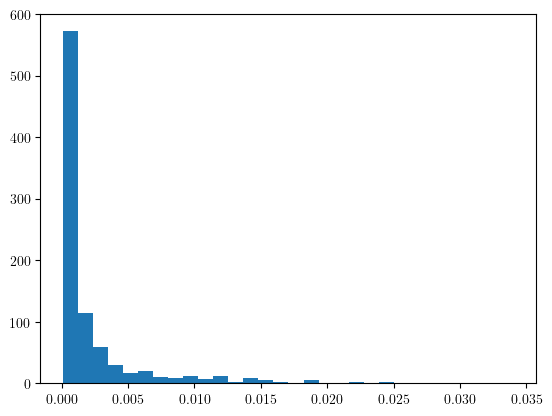

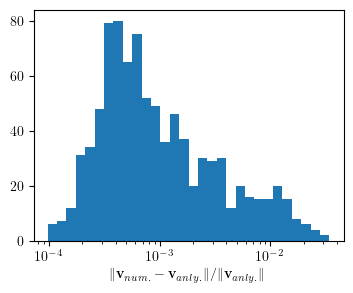

In [2]:
import matplotlib.pyplot as plt

plt.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "sans-serif",
        "font.sans-serif": ["Helvetica"],
        "ps.usedistiller": "xpdf",
    }
)

# Load the two results with pickle and combine them
with open("opt_problems_K90.pickle", "rb") as handle:
    opt_problems_K90 = pickle.load(handle)

with open("opt_problems_K100.pickle", "rb") as handle:
    opt_problems_K100 = pickle.load(handle)

opt_problems = {**opt_problems_K90, **opt_problems_K100}


# Plot the results as K be the x-axis,  Max error of v_i as y-axis, and average over all N random settings of b and lmbda, (R,L) as different lines
K_values = list(np.linspace(10, 100, 10, dtype=int))
R_values = [1, 10, 1000]
L_values = [1, 10, 1000]
combinations = itertools.product(K_values, R_values, L_values)

N=10
# error_norm = np.zeros((len(K_values), len(R_values)*len(L_values)*N))

errors = []
for i, (K, R, L) in enumerate(combinations):
    
    for j in range(N):
        
          
        opt_problem_key = (i, j)
        A_theoretical = opt_problems[opt_problem_key].A[
                    0 : K]/opt_problems[opt_problem_key].A[K]
        errors.append(
            np.linalg.norm(opt_problems[opt_problem_key].v_i_value  - A_theoretical)  /np.sqrt(K) / np.linalg.norm(A_theoretical)
            )
        
        # error_norm[K_values.index(K),R_values.index(R),L_values.index(L)] = np.mean(errors)

hist, bins, _ = plt.hist(errors, bins=30)
logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))


fig, ax = plt.subplots(figsize=(4,3))
ax.set_xscale('log')
ax.hist(errors, bins = logbins)
ax.set_xlabel(r"$\|{\mathbf{v}_{num.}- \mathbf{v}_{anly.}}\| / \| \mathbf{v}_{anly.} \|$")



plt.savefig("Figures/error_v_i.pdf", bbox_inches="tight")



